In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('../data/CDC_train.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [ ]:
import os
import requests
import time
from tqdm import tqdm

MAPBOX_TOKEN = "pk.eyJ1IjoibWFoaTE4IiwiYSI6ImNtamxhaGRyMjBnOXczaXM2Y3owNW1meGcifQ.1pjHTXOrC-mwA7uGaE-U9Q"
Z18_DIR = "house_images_dataset/zoom_18"
os.makedirs(Z18_DIR, exist_ok=True)

MAX_CREDITS = 45000 
current_usage_estimate = 2800 

def resume_zoom_18(df, token, used_credits):
    credits_spent = used_credits
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Zoom 18 Progress"):
        # STOP if we are nearing the free limit
        if credits_spent >= MAX_CREDITS:
            print(f"\n SAFETY STOP: Reached {credits_spent} requests.")
            break
            
        house_id = int(row['id'])
        lat, lon = row['lat'], row['long']
        
        file_path = os.path.join(Z18_DIR, f"{house_id}.jpg")
        # THE GUARD: SKIPS ALREADY DOWNLOADED IMAGES
        if os.path.exists(file_path):
            continue
            
        url = f"https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/{lon},{lat},18,0,0/400x400?access_token={token}"
        
        try:
            response = requests.get(url, timeout=20)
            
            # Every request counts as 1 credit
            credits_spent += 1
            
            if response.status_code == 200:
                with open(file_path, "wb") as f:
                    f.write(response.content)
            elif response.status_code == 429:
                print("\n Rate limit hit. Sleeping 30s...")
                time.sleep(30)
            elif response.status_code == 401:
                print("\n Invalid Token! Check your Mapbox account.")
                break
            
            # Stable delay
            time.sleep(0.12) 
            
        except Exception:
            time.sleep(5)

resume_zoom_18(data, MAPBOX_TOKEN, current_usage_estimate)

In [7]:
import os
Z18_DIR = "house_images_dataset/zoom_18"
image_files = [f for f in os.listdir(Z18_DIR) if f.lower().endswith(('.jpg','.jpeg'))]
valid_images = [f for f in image_files if os.path.getsize(os.path.join(Z18_DIR,f)) > 0]
missing_or_empty = [f for f in os.listdir(Z18_DIR) 
                    if os.path.getsize(os.path.join(Z18_DIR, f)) == 0]

print(f"Files detected with .jpg/.jpeg: {len(image_files)}")
print(f"Valid non-empty images: {len(valid_images)}")
print(f"Empty files: {len(missing_or_empty)}")

Files detected with .jpg/.jpeg: 16056
Valid non-empty images: 16056
Empty files: 0


In [8]:
all_files = os.listdir(Z18_DIR)
non_jpg_files = [f for f in all_files if not f.lower().endswith(('.jpg','.jpeg'))]
print(f"Files with other extensions or skipped by filter: {len(non_jpg_files)}")
print(non_jpg_files[:20])  

Files with other extensions or skipped by filter: 0
[]


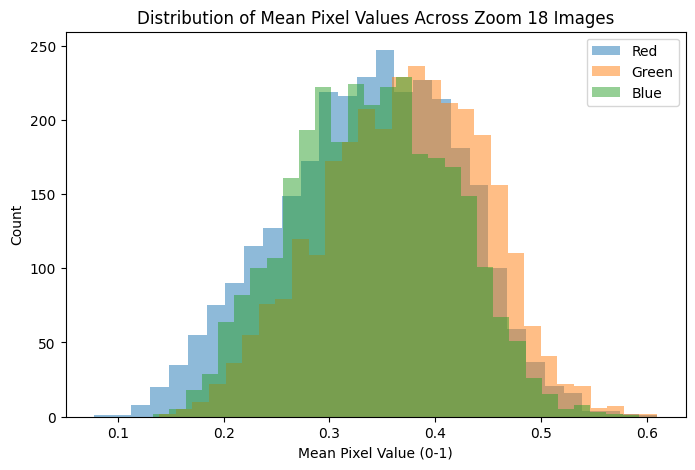

In [7]:
import random
from PIL import Image
sample_files = random.sample(image_files, 3000) 
pixel_means = []
pixel_stds = []

for img_file in sample_files:
    img = Image.open(os.path.join(Z18_DIR, img_file)).convert('RGB')
    arr = np.array(img) / 255.0
    pixel_means.append(arr.mean(axis=(0,1)))  
    pixel_stds.append(arr.std(axis=(0,1)))    

pixel_means = np.array(pixel_means)
pixel_stds = np.array(pixel_stds)

plt.figure(figsize=(8,5))
plt.hist(pixel_means[:,0], bins=30, alpha=0.5, label='Red')
plt.hist(pixel_means[:,1], bins=30, alpha=0.5, label='Green')
plt.hist(pixel_means[:,2], bins=30, alpha=0.5, label='Blue')
plt.xlabel('Mean Pixel Value (0-1)')
plt.ylabel('Count')
plt.title('Distribution of Mean Pixel Values Across Zoom 18 Images')
plt.legend()
plt.show()

The pixel distribution shows consistent lighting and exposure across the 16,056 images, with peaks centered between 0.3 and 0.5. The absence of spikes at the extreme ends (0 or 1) confirms that the dataset is free of corrupted "all-black" files or cloud-covered "all-white" images.

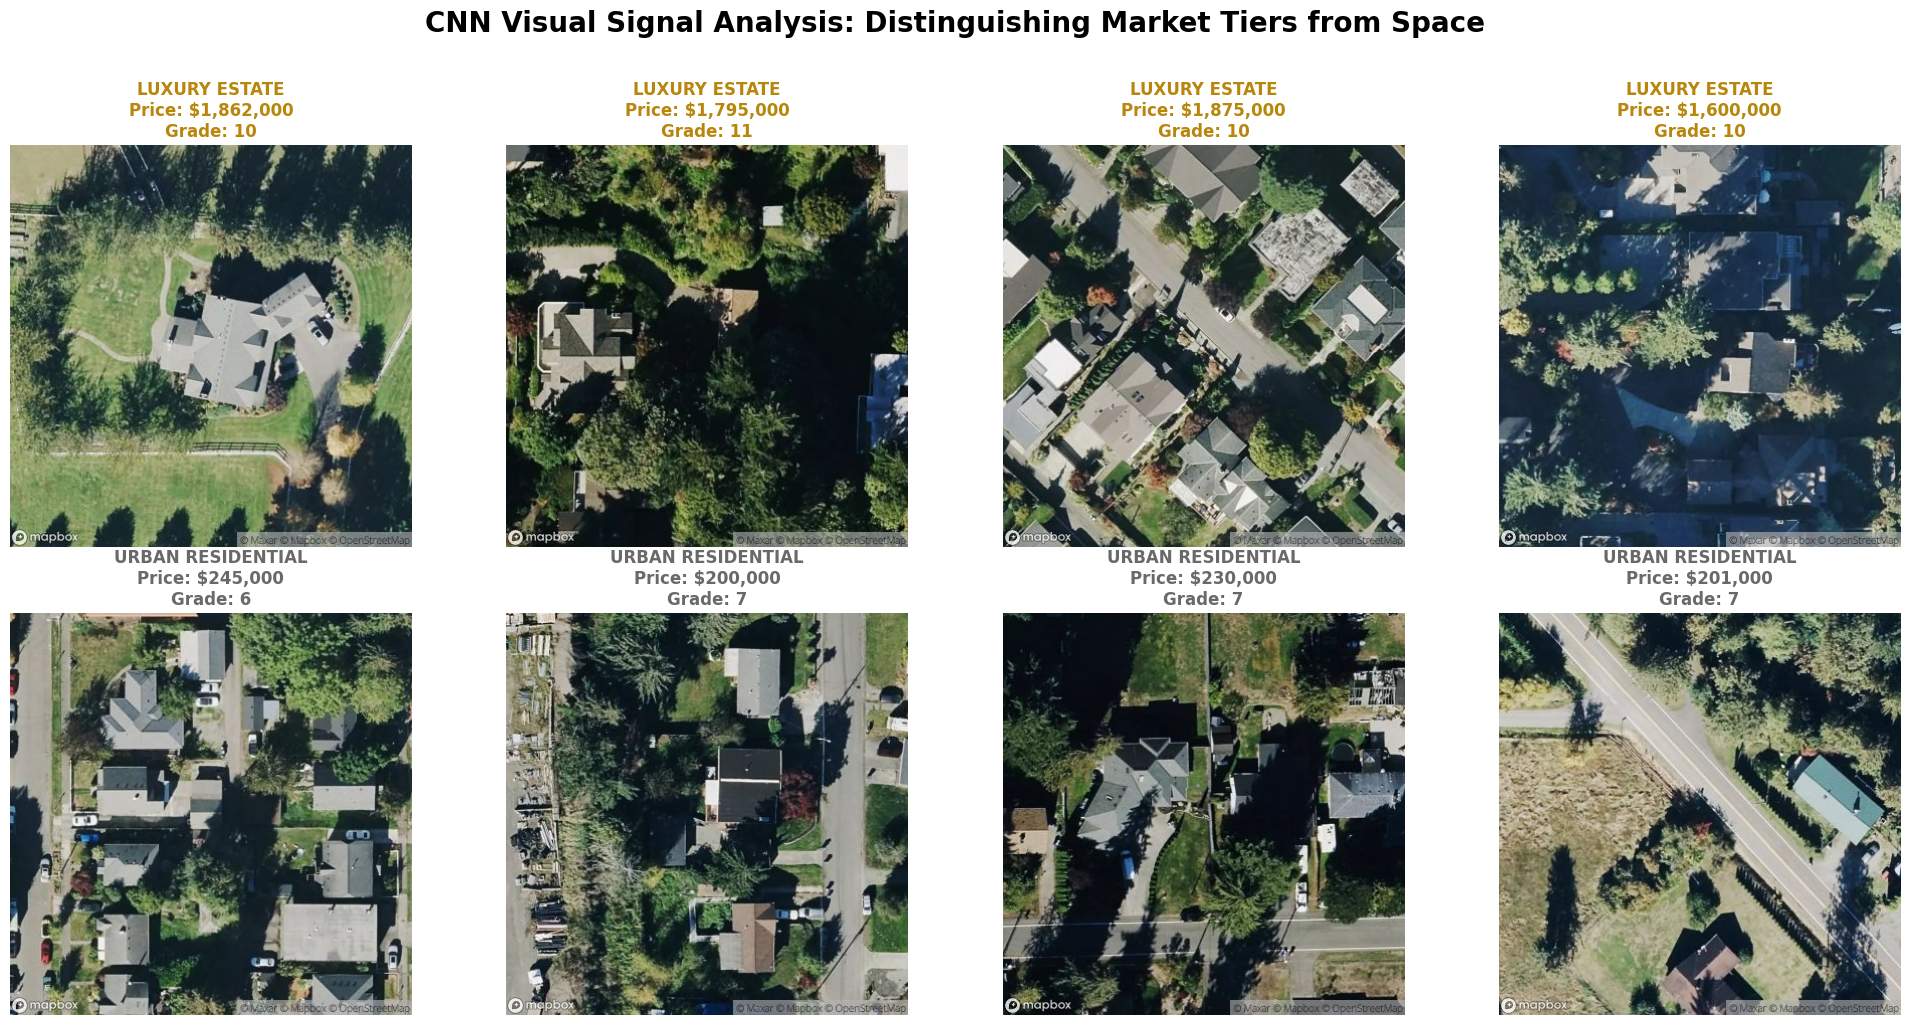

In [14]:
high_tier = df_viz[df_viz['price'] >= df_viz['price'].quantile(0.98)].sample(4, random_state=42)
low_tier = df_viz[df_viz['price'] <= df_viz['price'].quantile(0.15)].sample(4, random_state=42)

comparison_df = pd.concat([high_tier, low_tier])

plt.figure(figsize=(20, 10))
for i, (index, row) in enumerate(comparison_df.iterrows()):
    img_path = os.path.join(Z18_DIR, f"{int(row['id'])}.jpg")
    
    try:
        img = Image.open(img_path)
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        
        tier_color = 'darkgoldenrod' if i < 4 else 'dimgrey'
        tier_label = "LUXURY ESTATE" if i < 4 else "URBAN RESIDENTIAL"
        
        plt.title(f"{tier_label}\nPrice: ${int(row['price']):,}\nGrade: {int(row['grade'])}", 
                  fontsize=12, fontweight='bold', color=tier_color)
        plt.axis('off')
    except:
        continue

plt.suptitle("CNN Visual Signal Analysis: Distinguishing Market Tiers from Space", 
             fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('visual_contrast_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
test_df = pd.read_csv('../data/CDC_test.csv')

In [ ]:
import os
import requests
import time
from tqdm import tqdm

# 1. Update Directory for Test Dataset
TEST_Z18_DIR = "house_images_dataset/test_zoom_18"
os.makedirs(TEST_Z18_DIR, exist_ok=True)

# 2. Reuse your Mapbox Configuration
MAPBOX_TOKEN = "pk.eyJ1IjoibWFoaTE4IiwiYSI6ImNtamxhaGRyMjBnOXczaXM2Y3owNW1meGcifQ.1pjHTXOrC-mwA7uGaE-U9Q"

def fetch_test_images(df, token):
    credits_spent = 0 
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Fetching Test Images"):
        house_id = int(row['id'])
        lat, lon = row['lat'], row['long']
        
        file_path = os.path.join(TEST_Z18_DIR, f"{house_id}.jpg")
        
        # SKIPS ALREADY DOWNLOADED TEST IMAGES
        if os.path.exists(file_path):
            continue
            
        url = f"https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/{lon},{lat},18,0,0/400x400?access_token={token}"
        
        try:
            response = requests.get(url, timeout=20)
            credits_spent += 1
            
            if response.status_code == 200:
                with open(file_path, "wb") as f:
                    f.write(response.content)
            elif response.status_code == 429:
                time.sleep(30)
            elif response.status_code == 401:
                print("Token Error!")
                break
            
            time.sleep(0.12) 
            
        except Exception:
            time.sleep(5)

fetch_test_images(test_df, MAPBOX_TOKEN)

Fetching Test Images:   0%|          | 0/5404 [00:00<?, ?it/s]

Fetching Test Images: 100%|██████████| 5404/5404 [1:22:35<00:00,  1.09it/s]


In [ ]:
import os
TEST_Z18_DIR = "house_images_dataset/test_zoom_18"


test_image_files = [f for f in os.listdir(TEST_Z18_DIR) if f.lower().endswith(('.jpg', '.jpeg'))]
test_valid_images = [f for f in test_image_files if os.path.getsize(os.path.join(TEST_Z18_DIR, f)) > 0]
test_empty_files = [f for f in test_image_files if os.path.getsize(os.path.join(TEST_Z18_DIR, f)) == 0]

print("--- Test Dataset Image Audit ---")
print(f"Total files detected: {len(test_image_files)}")
print(f"Valid non-empty images: {len(test_valid_images)}")
print(f"Empty/Failed downloads: {len(test_empty_files)}")


--- Test Dataset Image Audit ---
Total files detected: 5385
Valid non-empty images: 5385
Empty/Failed downloads: 0


In [8]:
# Use the correct variable name from your audit
test_ids_set = set(test_df['id'].unique())
downloaded_ids = set([int(f.split('.')[0]) for f in test_valid_images])

missing_ids = list(test_ids_set - downloaded_ids)

print(f"Unique IDs in Test CSV: {len(test_ids_set)}")
print(f"Unique Images Downloaded: {len(downloaded_ids)}")
print(f"Missing unique IDs: {len(missing_ids)}")
print(f"Missing IDs list: {missing_ids}")

Unique IDs in Test CSV: 5396
Unique Images Downloaded: 5385
Missing unique IDs: 11
Missing IDs list: [np.int64(2422029094), np.int64(4037500230), np.int64(3526059115), np.int64(1588600045), np.int64(8728100781), np.int64(9266700175), np.int64(3438500781), np.int64(1328330290), np.int64(2426049079), np.int64(5379804888), np.int64(4024100670)]
